# Time Series Prediction


In [91]:
# @ Lukman copyright 
# MIT Licence

In [1]:
# for data frame analysis
import pandas as pd 

# for mathematical operations
import numpy as np 


# matplotlib library for plotting
import matplotlib.pyplot as plt
%matplotlib inline

# For Normalizing data
from sklearn.preprocessing import StandardScaler

# For statistical test
import scipy.stats as stats

# Split data set into training and test set
from sklearn.model_selection import train_test_split as tts

# SVN module
from sklearn import svm

# Kernel Functions used 
from sklearn.metrics.pairwise import rbf_kernel,laplacian_kernel

# module for chi square test
from scipy.stats import chisquare


# For dictionary 
from collections import defaultdict

# for use of tensorflow
import tensorflow as tf
#from tensorflow.nn.rnn import *
from tensorflow.python.ops  import *
from tensorflow.keras import regularizers

# for scaling arrays
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler


# for random sampling of validation set
import random

import yaml
import os
from utility import utils

%load_ext autoreload
%autoreload 2

In [2]:
# lightgbm module
import lightgbm as lgb

In [3]:
import json

In [95]:
# enable eager executinon
tf.enable_eager_execution()

In [96]:
tf.__version__

'1.15.0'

# Data Preprocessing 

In [4]:
################################################################################
# load config file
try:
    with open("../config.yml", 'r') as ymlfile:
            cfg = yaml.safe_load(ymlfile)
except (IOError):
    print('config file is required. Put config file in current directory')
################################################################################

In [5]:
# # current working directory
# cwd = os.getcwd()
# # set the base directory. base directo
# BASE_DIR = os.path.join( os.path.dirname( cwd), '' )
# # cleaned data dir
# cleanedpath= BASE_DIR + cfg['cleanedconfig']['cleanedDataV1']['cleanedDir'] 
# # clean data Name
# cleandataName = cfg['cleanedconfig']['cleanedDataV1']['cleanedName']
# # traina and validation data name
# trainName= cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfcleanTrain']
# validateName  = cfg['cleanedconfig']['cleanedDataV1']['TensorflowDataFlowConfig']['tfcleanValidate']
# validation_split = cfg['cleanedconfig']['cleanedDataV1']['validationSplit']

In [6]:
# current working directory
cwd = os.getcwd()
# set the base directory. base directo
BASE_DIR = os.path.join( os.path.dirname( cwd), '' )
# cleaned data dir
cleanedpath= BASE_DIR + cfg['cleanedconfig']['cleanedDataV2']['cleanedDir'] 
# clean data Name
cleandataName = cfg['cleanedconfig']['cleanedDataV2']['cleanedName']
# traina and validation data name
trainName= cfg['cleanedconfig']['cleanedDataV2']['TensorflowDataFlowConfig']['tfcleanTrain']
validateName  = cfg['cleanedconfig']['cleanedDataV2']['TensorflowDataFlowConfig']['tfcleanValidate']
validation_split = cfg['cleanedconfig']['cleanedDataV2']['validationSplit']

In [7]:
# I will Load only the zero meter data set 
# same syntax applied for other data set
#meterOneDataLOaded= pd.read_csv(cleanedpath +  cleandataName )
meterOneDataLOaded= pd.read_feather(cleanedpath +  cleandataName )

# all meter types data set could be analysed in same manner

In [8]:
# set index
meterOneDataLOaded.set_index('timestamp',inplace=True);

In [39]:
# x axis for test values
#test_timestamp = list(test.index.values)
#test_building_id = list(test.building_id.values)

In [40]:
#del test['building_id']
#del train['building_id']

#### Work with downloaded csv to preserve data type
Load the csv file and parse the data types of the datatset together into the
tensorflow load pipeline

In [9]:
#  evaluation metric
def log_root_mean_squared_error(y_true, y_pred):
    '''
    
    this is the loss function specified in kaggle competition
    '''
    
    y_pred = y_pred.get_label()
    print(y_pred)
        
    return 'error',np.sqrt(np.mean (np.square(  (np.log1p(np.y_pred+1)- np.log1p(y_true+1)) )   )   )



def root_mean_squared_error2(y_true, y_pred):
    '''
    this is 1.- mean squared
    root mean squared is a value between 0 and 1 
    to reflect accuracy use 1-rms
    '''
        
    return  np.sqrt(np.mean( ( np.square ( y_pred - y_true    )   )   ))

In [10]:
# ====================
# define custom objective function
#======================


# self-defined objective function
# f(preds: array, train_data: Dataset) -> grad: array, hess: array
# log likelihood loss
#def loglikelihood(preds, train_data):
#    labels = train_data.get_label()
#    preds = 1. / (1. + np.exp(-preds))
#    grad = preds - labels
#    hess = preds * (1. - preds)
#    return grad, hess

# ====================
# define custom objective function
#======================



# self-defined objective function
# f(preds: array, train_data: Dataset) -> grad: array, hess: array
# log likelihood loss
#def logerror(preds, train_data):
#    train_data = train_data.get_label()
#    preds = 1. / (1. + np.exp(-preds))
#    #preds = np.square(  (np.log1p(train_data+1)- np.log1p(preds+1)) )   
#    grad = np.square(preds - train_data)
#    hess = preds * (1. - preds)
#    return grad, hess

### Training Data Preparation

In [10]:
# training and target variable
y_train = meterOneDataLOaded['meter_reading']
X_train = meterOneDataLOaded.drop('meter_reading', axis=1)

In [11]:
# load traning and target variable
# TO DO:
#      Include Validation set as in 
#      https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/advanced_example.py
lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)

In [20]:
# Model Parameters
# change boosting type to dart to try it out
# 
params = {
    'boosting_type': 'gbdt', # dart
    'objective': 'regression',
    'metric': 'l2',
    'num_leaves': 400,
    'num_iterations': 900000000,
    'num_threads':3,
    'learning_rate': 0.5,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.4,
    'bagging_freq': 5,
    'verbose': 0
}

In [16]:
# column names
names = list(meterOneDataLOaded.columns)[1:]


In [17]:
names

['square_feet',
 'air_temperature',
 'dew_temperature',
 'month',
 'day',
 'hour',
 'primary_use_Education',
 'primary_use_Entertainment/public assembly',
 'primary_use_Food sales and service',
 'primary_use_Healthcare',
 'primary_use_Lodging/residential',
 'primary_use_Manufacturing/industrial',
 'primary_use_Office',
 'primary_use_Other',
 'primary_use_Parking',
 'primary_use_Public services',
 'primary_use_Religious worship',
 'primary_use_Retail',
 'primary_use_Services',
 'primary_use_Technology/science',
 'primary_use_Utility',
 'primary_use_Warehouse/storage',
 'site_id_0',
 'site_id_1',
 'site_id_2',
 'site_id_3',
 'site_id_4',
 'site_id_5',
 'site_id_6',
 'site_id_7',
 'site_id_8',
 'site_id_9',
 'site_id_10',
 'site_id_11',
 'site_id_12',
 'site_id_13',
 'site_id_14',
 'site_id_15']

In [18]:
# feature names index for use in model
cat_features = [names.index(i) for i in names][6:]

### Train Model

In [19]:
# Train model
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=10000000,
                feval=log_root_mean_squared_error,
                #fobj=logerror,
                feature_name=names, 
                categorical_feature=cat_features)


/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/bigdata-lap/anaconda3/envs/cat/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [18]:
print('7th feature name is:', lgb_train.feature_name[6])

7th feature name is: primary_use_Education


### Save Model And Feature Importance

In [19]:
checkpoint_path = cfg['savedModel']['myname']['Dir4'] 


In [20]:
# make path if not available
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

In [21]:
print('Saving model...')
# save model to file
gbm.save_model( checkpoint_path + cfg['savedModel']['myname']['modelName4'])

Saving model...


In [87]:
#print('Dumping model to JSON...')
# dump model to JSON (and save to file)
#model_json = gbm.dump_model()

#with open('model.json', 'w+') as f:
#    json.dump(model_json, f, indent=4)


In [22]:
print('Feature names:', gbm.feature_name())

Feature names: ['square_feet', 'air_temperature', 'dew_temperature', 'month', 'day', 'hour', 'primary_use_Education', 'primary_use_Entertainment/public_assembly', 'primary_use_Food_sales_and_service', 'primary_use_Healthcare', 'primary_use_Lodging/residential', 'primary_use_Manufacturing/industrial', 'primary_use_Office', 'primary_use_Other', 'primary_use_Parking', 'primary_use_Public_services', 'primary_use_Religious_worship', 'primary_use_Retail', 'primary_use_Services', 'primary_use_Technology/science', 'primary_use_Utility', 'primary_use_Warehouse/storage', 'site_id_0', 'site_id_1', 'site_id_2', 'site_id_3', 'site_id_4', 'site_id_5', 'site_id_6', 'site_id_7', 'site_id_8', 'site_id_9', 'site_id_10', 'site_id_11', 'site_id_12', 'site_id_13', 'site_id_14', 'site_id_15']


In [23]:
# feature name and importance value 
feature_importance = list(zip(list(gbm.feature_name()), list(gbm.feature_importance())))

In [24]:
# feature importance 
feature_importance

[('square_feet', 110),
 ('air_temperature', 27),
 ('dew_temperature', 6),
 ('month', 29),
 ('day', 13),
 ('hour', 23),
 ('primary_use_Education', 19),
 ('primary_use_Entertainment/public_assembly', 7),
 ('primary_use_Food_sales_and_service', 0),
 ('primary_use_Healthcare', 4),
 ('primary_use_Lodging/residential', 10),
 ('primary_use_Manufacturing/industrial', 1),
 ('primary_use_Office', 10),
 ('primary_use_Other', 1),
 ('primary_use_Parking', 7),
 ('primary_use_Public_services', 10),
 ('primary_use_Religious_worship', 0),
 ('primary_use_Retail', 1),
 ('primary_use_Services', 5),
 ('primary_use_Technology/science', 1),
 ('primary_use_Utility', 1),
 ('primary_use_Warehouse/storage', 1),
 ('site_id_0', 11),
 ('site_id_1', 3),
 ('site_id_2', 9),
 ('site_id_3', 16),
 ('site_id_4', 8),
 ('site_id_5', 6),
 ('site_id_6', 2),
 ('site_id_7', 5),
 ('site_id_8', 4),
 ('site_id_9', 10),
 ('site_id_10', 5),
 ('site_id_11', 1),
 ('site_id_12', 6),
 ('site_id_13', 8),
 ('site_id_14', 4),
 ('site_id_15

### Testing model
No model testing for now

In [25]:
# test data path
testpath= BASE_DIR + cfg['cleanedtest']['TargetDir']
testDataName= cfg['cleanedtest']['testFeatureSet']
testName = cfg['cleanedtest']['testData']
testzero =  cfg['cleanedtest']['testDatasetName']

In [26]:
local_learn = True

In [29]:
# execute this once , LLOCAL learn variable ensure it does not execute 2ce to save time
# set local_learn in cell above to true to run again
# increase testpoints to collect more datapoints

if local_learn:
    testpoints = 10000
    test_model = pd.read_csv(testpath + testName,nrows=testpoints)
    #prototype_data.to_csv('prototype_data.csv',index=None)
else:
    local_learn = False

In [30]:
# training and target variable
y_test = test_model['meter_reading']
X_test = test_model.drop('meter_reading', axis=1)

In [32]:
print('Loading model to predict...')
# load model to predict
bst = lgb.Booster(model_file= checkpoint_path + cfg['savedModel']['myname']['modelName4'])

Loading model to predict...


In [40]:

# model prediction
predictions = bst.predict(X_test)


Text(0.5, 0, 'Iterations')

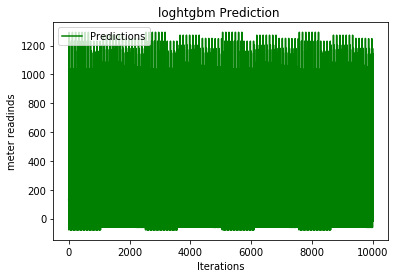

In [41]:

plt.plot(predictions,"-g" ,label='Predictions')
#plt.plot(true_values, "-r",label='True Values')
plt.legend(loc="upper left")
plt.title('loghtgbm Prediction ')
plt.ylabel('meter readinds')
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

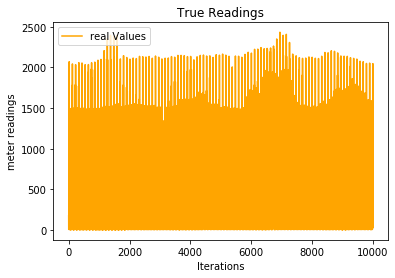

In [35]:

plt.plot(y_test,"-g" ,label='real Values', color='orange')
#plt.plot(true_values, "-r",label='True Values')
plt.legend(loc="upper left")
plt.title('True Readings')
plt.ylabel('meter readings')
plt.xlabel('Iterations')

In [42]:
# to plot per building
test_predicted = pd.DataFrame(list(zip(list(true_readings.building_id),list(true_readings.timestamp),list(predictions))),columns= ['building_id','timestamp', 'meter_reading' ] )

In [36]:
# upload true meter reADINGS
#true_readings = pd.read_csv(testpath + testzero) 
true_readings = pd.read_csv(testpath + testzero,nrows=testpoints) 


del true_readings['Unnamed: 0']

In [169]:

from utility import utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


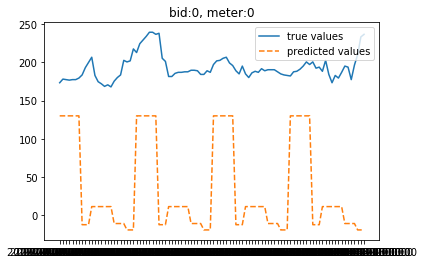

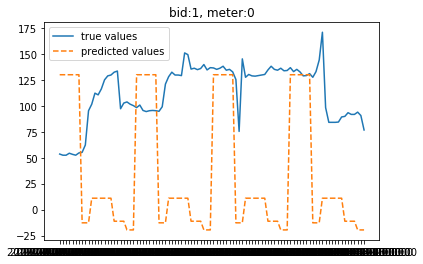

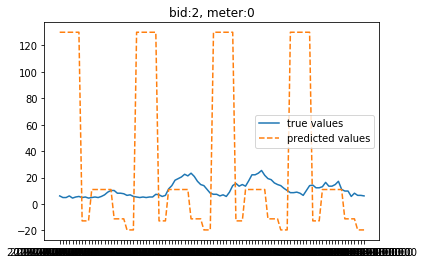

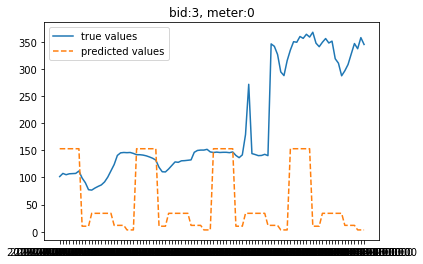

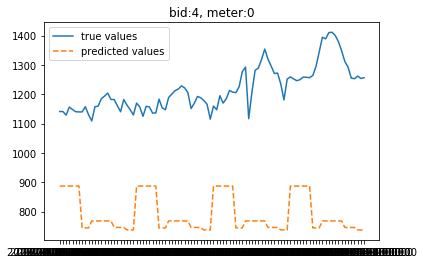

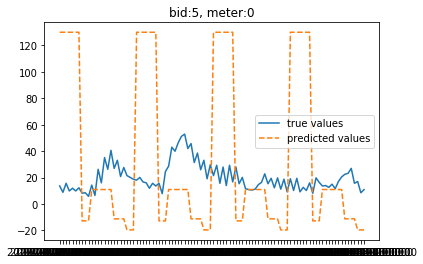

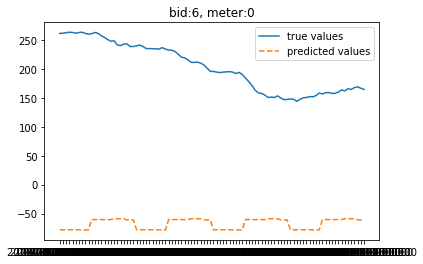

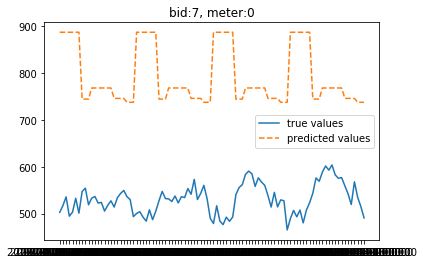

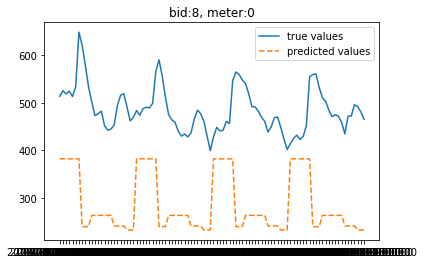

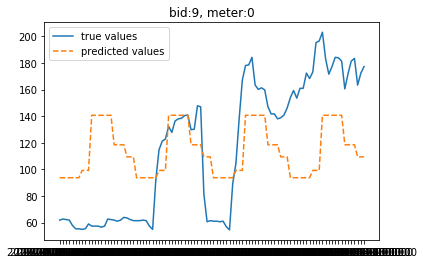

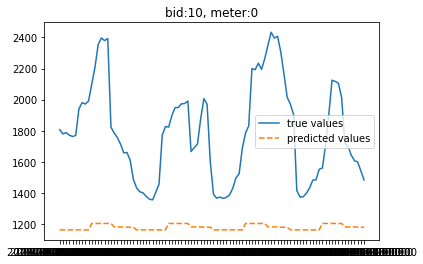

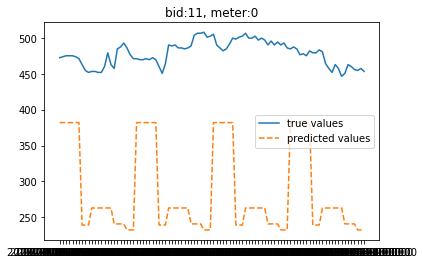

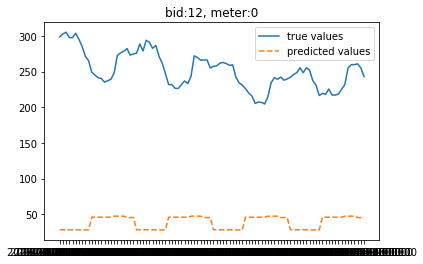

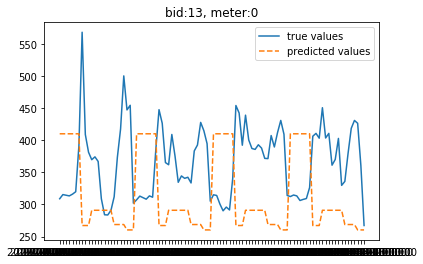

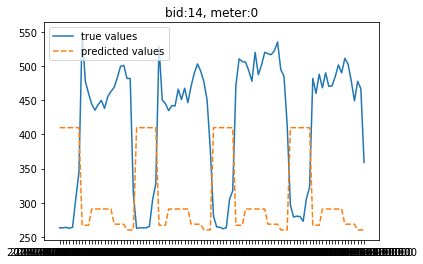

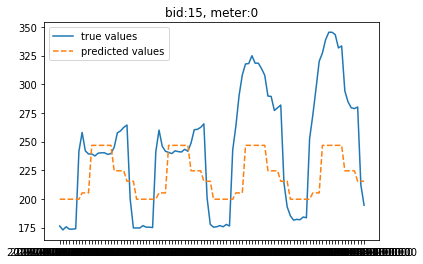

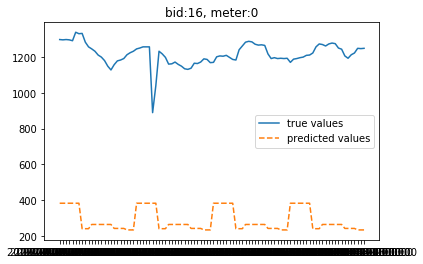

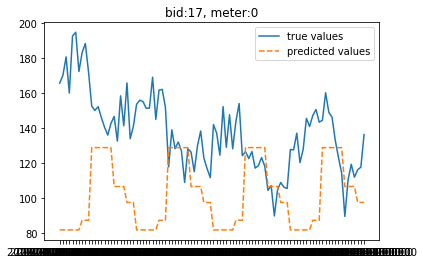

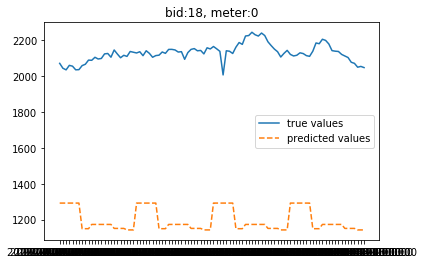

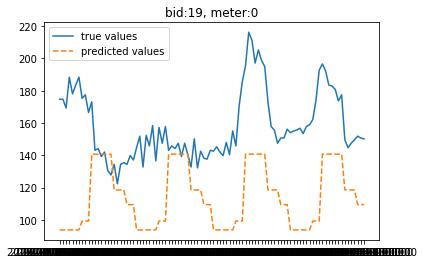

In [44]:
utils.plot_meter(true_readings,test_predicted,bn=20)